# Customer Churn Prediction
Customer **churn** refers to the process where customers stop using a company's services. In the highly competitive Indian telecom sector, retaining customers is critical for business growth, as customers frequently switch between providers.

The goal of this project is to **predict customer churn** using demographic and usage data from four major telecom providers in India: Airtel, Reliance Jio, Vodafone, and BSNL.

## Libraries

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn import tree

##  Import Datasets

In [121]:
# Telecom datasets
demographics_df = pd.read_csv("/content/telecom_demographics.csv")
usage_df = pd.read_csv("/content/telecom_usage.csv")

In [122]:
demographics_df.head()

,customer_id,telecom_partner,gender,age,state,city,pincode,registration_event,num_dependents,estimated_salary
0,15169,Airtel,F,26,Himachal Pradesh,Delhi,667173,2020-03-16,4,85979
1,149207,Airtel,F,74,Uttarakhand,Hyderabad,313997,2022-01-16,0,69445
2,148119,Airtel,F,54,Jharkhand,Chennai,549925,2022-01-11,2,75949
3,187288,Reliance Jio,M,29,Bihar,Hyderabad,230636,2022-07-26,3,34272
4,14016,Vodafone,M,45,Nagaland,Bangalore,188036,2020-03-11,4,34157


In [123]:
usage_df.head()

,customer_id,calls_made,sms_sent,data_used,churn
0,15169,75,21,4532,1
1,149207,35,38,723,1
2,148119,70,47,4688,1
3,187288,95,32,10241,1
4,14016,66,23,5246,1


In [124]:
# Merge datasets on customer_id
df = pd.merge(demographics_df, usage_df, on="customer_id")
df.head()

,customer_id,telecom_partner,gender,age,state,city,pincode,registration_event,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,15169,Airtel,F,26,Himachal Pradesh,Delhi,667173,2020-03-16,4,85979,75,21,4532,1
1,149207,Airtel,F,74,Uttarakhand,Hyderabad,313997,2022-01-16,0,69445,35,38,723,1
2,148119,Airtel,F,54,Jharkhand,Chennai,549925,2022-01-11,2,75949,70,47,4688,1
3,187288,Reliance Jio,M,29,Bihar,Hyderabad,230636,2022-07-26,3,34272,95,32,10241,1
4,14016,Vodafone,M,45,Nagaland,Bangalore,188036,2020-03-11,4,34157,66,23,5246,1


##  Feature Engineering

### Handle Missing Values

In [125]:
df.isna().sum()

,0
customer_id,0
telecom_partner,0
gender,0
age,0
state,0
city,0
pincode,0
registration_event,0
num_dependents,0
estimated_salary,0


### Setting X and y variables

In [126]:
# Set target variable
y = df["churn"]

In [127]:
# Set feature variables and drop unnecessary columns
X = df.drop(columns=["customer_id", "pincode", "registration_event", "churn"])

In [128]:
# Gather numerical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Gather catgorical columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

print("Numerical Columns:", num_cols)
print("\nCatgorical Columns:", cat_cols)

Numerical Columns: ['age', 'num_dependents', 'estimated_salary', 'calls_made', 'sms_sent', 'data_used']

Catgorical Columns: ['telecom_partner', 'gender', 'state', 'city']


## Encode Categorical and Scale Numerical Features

### Ordinal Encoder

In [129]:
# Scale numerical features
scaler = StandardScaler()
X_num_cols_scaled = scaler.fit_transform(X[num_cols])

In [130]:
# Encode categorical features
encoder = OrdinalEncoder()
X_cat_cols_encoded = encoder.fit_transform(X[cat_cols])

In [131]:
# Convert scaled and encoded features to dataframes
X_num_cols_scaled_df = pd.DataFrame(X_num_cols_scaled, columns=num_cols)
X_cat_cols_encoded_df = pd.DataFrame(X_cat_cols_encoded, columns=encoder.get_feature_names_out(cat_cols))

# Combine numerical and categorical features
X_processed_ordinal = pd.concat([X_num_cols_scaled_df, X_cat_cols_encoded_df],
                                axis=1)

X_processed_ordinal.head()

,age,num_dependents,estimated_salary,calls_made,sms_sent,data_used,telecom_partner,gender,state,city
0,-1.222970,1.436539,0.011981,0.846076,-0.222385,-0.159488,0.0,0.0,8.0,2.0
1,1.696304,-1.411346,-0.428423,-0.496344,0.938056,-1.454896,0.0,0.0,26.0,3.0
2,0.479940,0.012596,-0.255181,0.678273,1.552407,-0.106434,0.0,0.0,9.0,1.0
3,-1.040515,0.724568,-1.365302,1.517286,0.528489,1.782094,2.0,1.0,3.0,3.0
4,-0.067424,1.436539,-1.368365,0.544031,-0.085862,0.083337,3.0,1.0,17.0,0.0


### One-hot Encoder

In [132]:
# Create onehot encoder
encoder = OneHotEncoder(sparse_output=False)

# Encode categorical features using onehot encoder
X_cat_cols_onehot = encoder.fit_transform(X[cat_cols])

In [133]:
# Convert scaled/encoded to dataframes
X_num_cols_scaled_df = pd.DataFrame(X_num_cols_scaled, columns=num_cols)
X_cat_cols_encoded_df = pd.DataFrame(X_cat_cols_onehot, columns=encoder.get_feature_names_out(cat_cols))

# Combine numerical and categorical features
X_processed_onehot = pd.concat([X_num_cols_scaled_df, X_cat_cols_encoded_df],
                               axis=1)

X_processed_onehot.head()

,age,num_dependents,estimated_salary,calls_made,sms_sent,data_used,telecom_partner_Airtel,telecom_partner_BSNL,telecom_partner_Reliance Jio,telecom_partner_Vodafone,...,state_Tripura,state_Uttar Pradesh,state_Uttarakhand,state_West Bengal,city_Bangalore,city_Chennai,city_Delhi,city_Hyderabad,city_Kolkata,city_Mumbai
0,-1.222970,1.436539,0.011981,0.846076,-0.222385,-0.159488,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.696304,-1.411346,-0.428423,-0.496344,0.938056,-1.454896,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.479940,0.012596,-0.255181,0.678273,1.552407,-0.106434,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,-1.040515,0.724568,-1.365302,1.517286,0.528489,1.782094,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.067424,1.436539,-1.368365,0.544031,-0.085862,0.083337,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Decision Tree Model

In [134]:
# Train and evaluate DT model
def train_eval_dt(X_train, X_test,  y_train, y_test, max_depth=None, plot=False):
  clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)  # Create DT Model
  clf.fit(X_train, y_train)  # Train the model
  y_pred = clf.predict(X_test)  # Predictions

  # DT Visualization
  if plot:
    plt.figure(figsize=(20,10))
    tree.plot_tree(clf, filled=True, max_depth=4)

  return accuracy_score(y_test, y_pred)

In [135]:
# Split ordinal encoded data
X_train_ord, X_test_ord, y_train, y_test = train_test_split(X_processed_ordinal, y, test_size=0.3, random_state=42)

# Split onehot encoded data
X_train_hot, X_test_hot, y_train, y_test = train_test_split(X_processed_onehot, y, test_size=0.3, random_state=42)

# Train DT models with different depths
accuracy_dt_ord = train_eval_dt(X_train_ord, X_test_ord, y_train, y_test)
accuracy_dt_hot = train_eval_dt(X_train_hot, X_test_hot, y_train, y_test)

print(f"Ordinal Encoding Accuracy: {accuracy_dt_ord:.2f}")
print(f"One-hot Encoding Accuracy: {accuracy_dt_hot:.2f}")

Ordinal Encoding Accuracy: 0.66
One-hot Encoding Accuracy: 0.65


In [143]:
#  Different depths (shallow to deep)
depths = [1,2,3,5,7,10,12,15,20,50,None]

# Test on ordinal encoding
print("Ordinal Encoding")
for max_depth in depths:
  accuracy_dt = train_eval_dt(X_train_ord, X_test_ord, y_train, y_test, max_depth)
  print(f"Accuracy DT with max_depth={max_depth}: {accuracy_dt:.2f}")

# Test on onehot encoding
print("\nOne-hot Encoding")
for max_depth in depths:
    accuracy_dt = train_eval_dt(X_train_hot, X_test_hot, y_train, y_test, max_depth)
    print(f"Accuracy DT with max_depth={max_depth}: {accuracy_dt:.2f}")

Ordinal Encoding
Accuracy DT with max_depth=1: 0.79
Accuracy DT with max_depth=2: 0.79
Accuracy DT with max_depth=3: 0.79
Accuracy DT with max_depth=5: 0.79
Accuracy DT with max_depth=7: 0.78
Accuracy DT with max_depth=10: 0.77
Accuracy DT with max_depth=12: 0.74
Accuracy DT with max_depth=15: 0.71
Accuracy DT with max_depth=20: 0.66
Accuracy DT with max_depth=50: 0.66
Accuracy DT with max_depth=None: 0.66

One-hot Encoding
Accuracy DT with max_depth=1: 0.79
Accuracy DT with max_depth=2: 0.79
Accuracy DT with max_depth=3: 0.79
Accuracy DT with max_depth=5: 0.79
Accuracy DT with max_depth=7: 0.78
Accuracy DT with max_depth=10: 0.78
Accuracy DT with max_depth=12: 0.76
Accuracy DT with max_depth=15: 0.74
Accuracy DT with max_depth=20: 0.71
Accuracy DT with max_depth=50: 0.65
Accuracy DT with max_depth=None: 0.65


0.7876923076923077

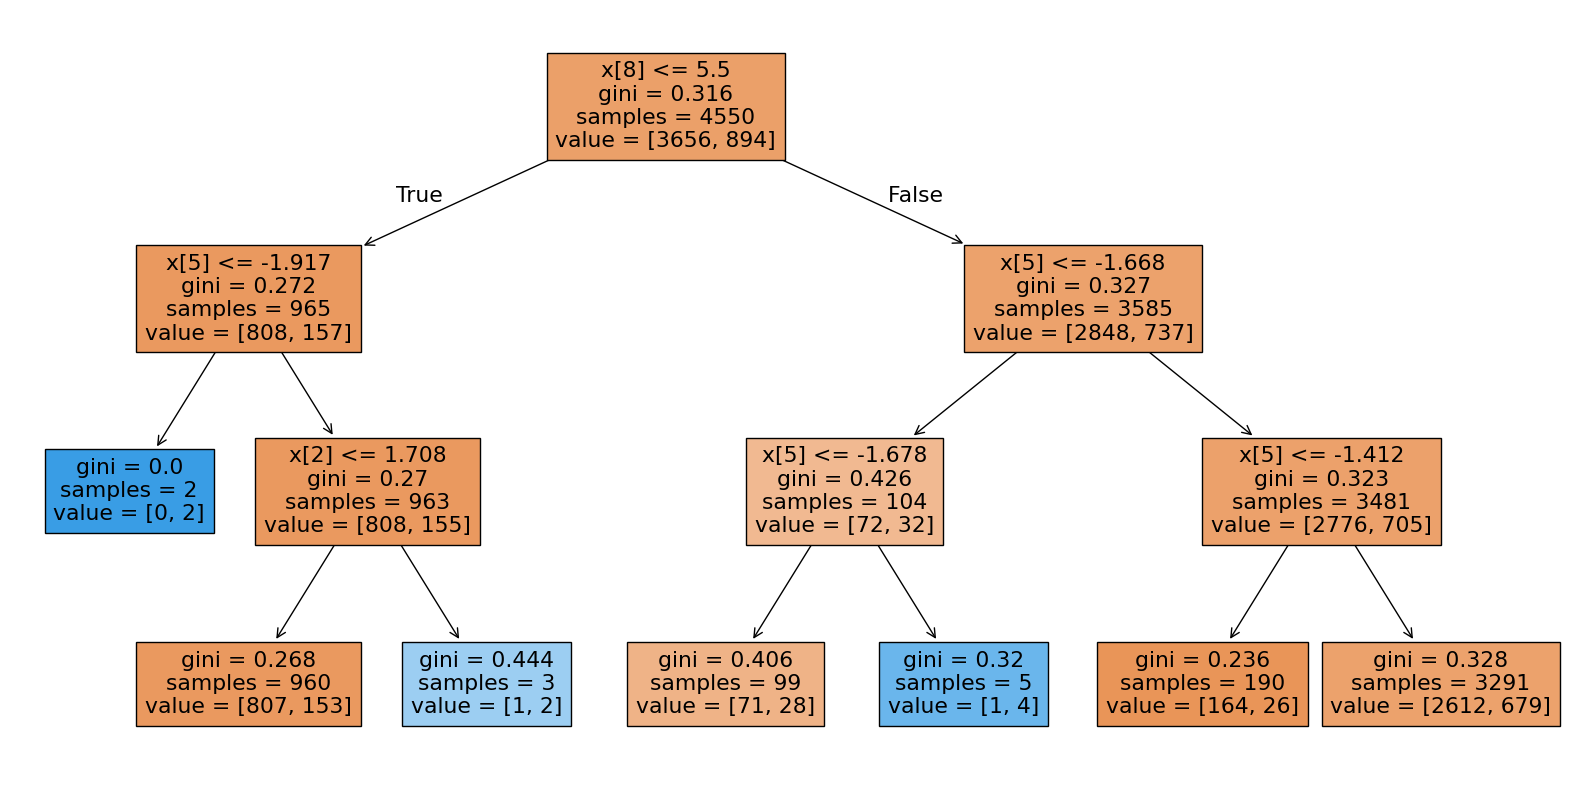

In [137]:
# Use max depth of 3
train_eval_dt(X_train_ord, X_test_ord, y_train, y_test, max_depth=3,plot=True)

## Random Forest Model

In [138]:
# Create Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_ord, y_train)  # Training
y_pred_rf = rf_model.predict(X_test_ord)  # Testing

print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")

Random Forest Accuracy: 0.79


## Feature Importance in Decision Trees

In [139]:
def plot_feature_importance(X, y, max_depth=None):

    clf = DecisionTreeClassifier(max_depth=max_depth, random_state=42)  # Initialize DT
    clf.fit(X, y)  # Training

    # Get feature importance
    importance = clf.feature_importances_  # Measures how much each feature contributes to impurity (Gini)
    features = np.array(num_cols + cat_cols)

    # Filter non-zero feature importance
    non_zero_idx = importance > 0
    non_zero_importance = importance[non_zero_idx]
    non_zero_features = features[non_zero_idx]

    # Sort features by importance
    sorted_idx = np.argsort(non_zero_importance)
    sorted_features = non_zero_features[sorted_idx]
    sorted_importance = non_zero_importance[sorted_idx]
    print(sorted_features, sorted_importance)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    bars = plt.barh(sorted_features, sorted_importance, color='skyblue')

    # Add value labels next to the bars
    for bar, value in zip(bars, sorted_importance):
        plt.text(bar.get_width() +0.002, bar.get_y() + bar.get_height()/2, f'{value:.2f}', va='center')

    # Remove x-ticks
    plt.xticks([])

    # Set labels and title
    plt.xlabel('Feature Importance')
    plt.title(f'Feature Importance in Decision Tree with max_depth = {max_depth}')

    # Invert y-axis to have the most important feature on top
    plt.gca().invert_yaxis()

['estimated_salary' 'state' 'data_used'] [0.11268378 0.20473191 0.68258431]
['city' 'sms_sent' 'estimated_salary' 'age' 'calls_made' 'state'
 'data_used'] [0.03072601 0.0418796  0.08199819 0.13266661 0.15566835 0.16156658
 0.39549467]
['num_dependents' 'gender' 'telecom_partner' 'city' 'sms_sent' 'age'
 'state' 'calls_made' 'data_used' 'estimated_salary'] [0.00955059 0.01363783 0.04158383 0.04955298 0.09510304 0.10918093
 0.12943764 0.15754668 0.18884212 0.20556436]


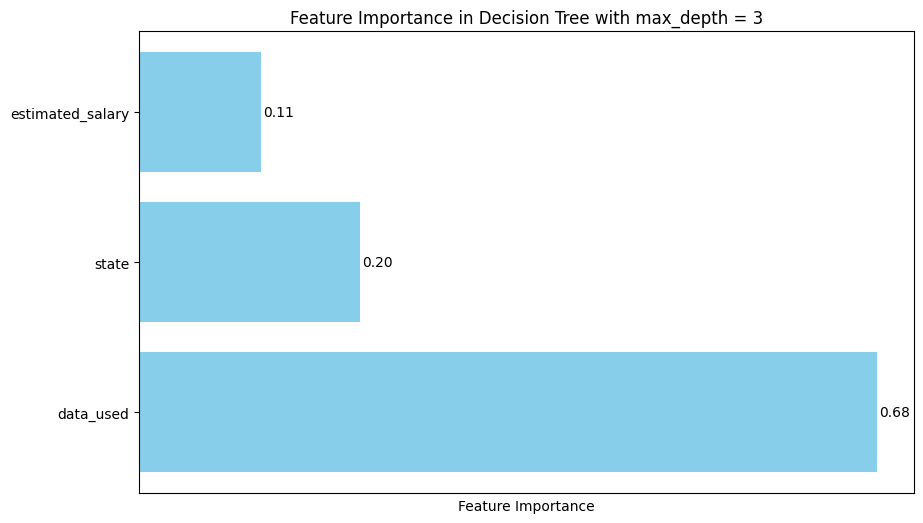

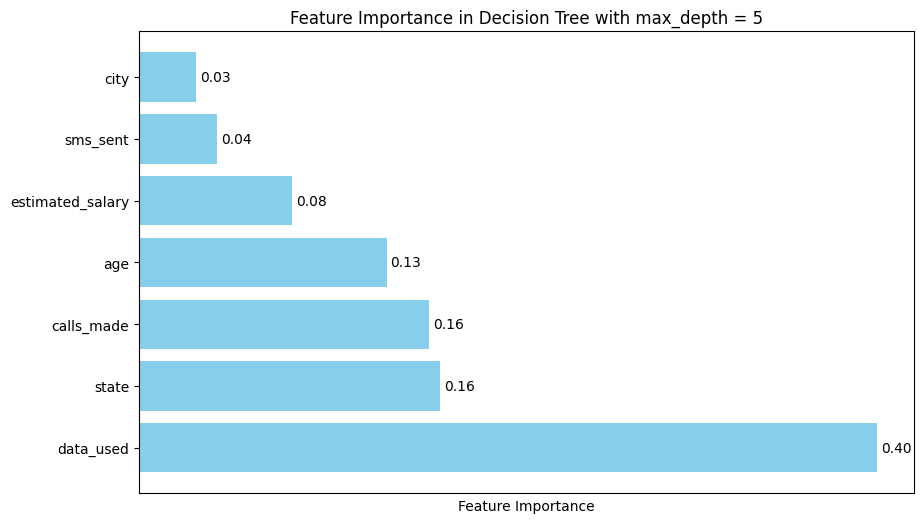

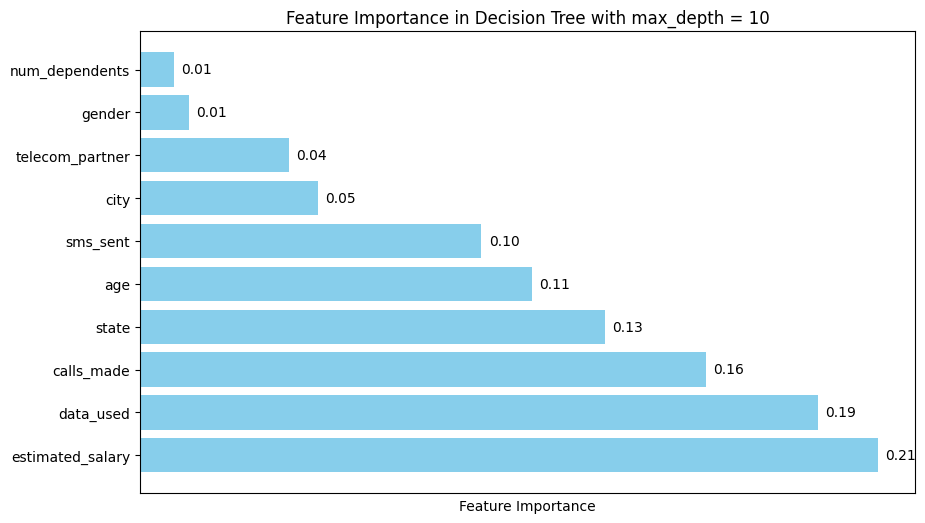

In [142]:
for depth in [3,5,10]:
    plot_feature_importance(X_train_ord, y_train, max_depth=depth)

# Key Findings

Effect of Ordinal and One-hot Encoding

---

* The results of ordinal and onehot encoding had **no significant difference** on the accuracy at the same or different depths.

Tree Depth Effects (Underfitting vs Overfitting)

---

* Shallow trees **underfit** the data while deep trees **overfit** the data.

* Underfitting occured from at depths 1 and 2. Overfitting occured on trees of depth 7 or more.

* Choosing max depth **between 3 and 5** is the best predictive performance for churn.

Random Forest vs Decision Tree

---

* Random Forest had similar accuracy to the Decision Tree.
* It did not provide a substantial accuracy boost, therefore, using Decision Trees are sufficient.

Feature Importance

---
* Shallower trees (3, 5), the amount of **data used** was the most important factor for determining customer churn.

* For the deeper tree (10), **estimated salary** was the most important feature, followed be data used.
